In [11]:
import re
import os
from dotenv import load_dotenv
from collections import Counter
from operator import itemgetter
# import pypdf
# from pypdf import PdfReader
# from pdfminer.high_level import extract_text as fallback_text_extraction
from pprint import pprint
from nltk.corpus import stopwords
import tiktoken

import matplotlib.pyplot as plt
import seaborn as sns

from langchain import hub
from langchain.load import dumps, loads
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI

load_dotenv()

True

In [5]:
CHROMA_PATH = "chromadb"
DOCUMENTS_PATH = "data/Machine Learning- Algorithms, Real-World Applications and Research Directions.pdf"

# Load Document

In [6]:
def load_documents(path):
    reader = PyPDFLoader(file_path=path)
    docs = reader.load()
    
    return docs

docs = load_documents(DOCUMENTS_PATH)

# EDA

In [7]:
list_doc = [doc.page_content for doc in docs]
texts = "".join(list_doc)

In [8]:
def visualize_top_words(texts, top_n=15, color='skyblue'):
    # Lowercase the text
    texts = texts.lower()
    # Remove special characters, numbers, and punctuation
    texts = re.sub(r"[^a-z\s]", "", texts)
    
    words = texts.split()
    filtered_words = [word for word in words if word not in stopwords.words("english")]
    
    word_counts = Counter(filtered_words)
    word_counts_sw = Counter(words)

    common_words = word_counts.most_common(top_n)
    common_words_sw = word_counts_sw.most_common(top_n)

    words, counts = zip(*common_words)
    words_sw, counts_sw = zip(*common_words_sw)
    
    # Plot bar chart horizontal
    fig, axs = plt.subplots(1,2, figsize=(15, 7))
    axs[0].barh(words, counts, color=color)
    axs[0].set_xlabel('Frequency')
    axs[0].set_title(f'Top {top_n} Most Frequent Words in Documents')
    axs[0].invert_yaxis()
    
    axs[1].barh(words_sw, counts_sw, color=color)
    axs[1].set_xlabel('Frequency')
    axs[1].set_title(f'Top {top_n} Most Frequent Words in Documents (with stopwords)')
    axs[1].invert_yaxis() 
    
    plt.show()

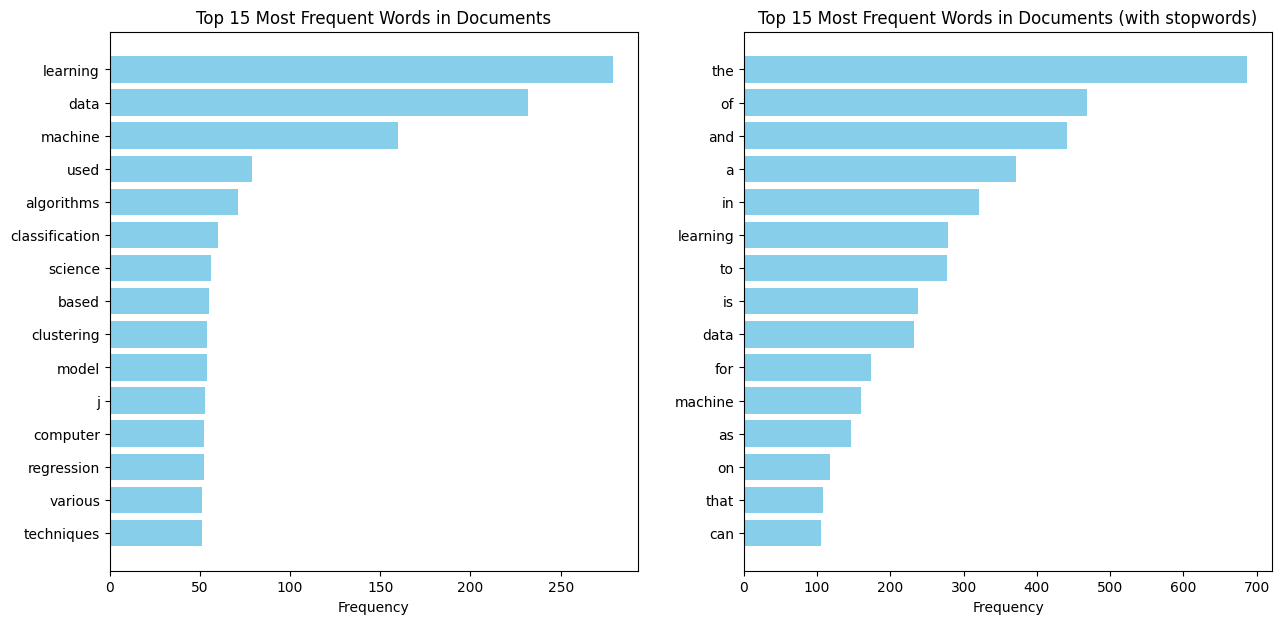

In [9]:
visualize_top_words(texts, color='skyblue')

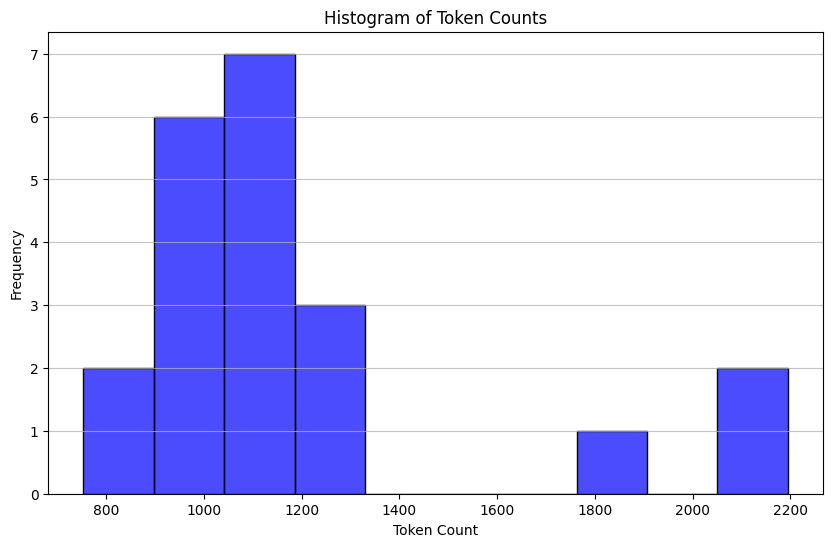

In [12]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

# Calculate the number of tokens for each document
counts = [num_tokens_from_string(txt, "cl100k_base") for txt in list_doc]

# Plotting the histogram of token counts
plt.figure(figsize=(10, 6))
sns.histplot(counts, color="blue", edgecolor="black", alpha=0.7)
# sns.histplot(counts, kde=True, kde_kws={"cut": 3})
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Display the histogram
plt.show()

# Data Preprocessing

In [13]:
char_split = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200
)
docs_chunks = char_split.split_documents(docs)

In [14]:
# create db from chunks of documents
vectorstore = Chroma.from_documents(
    documents=docs_chunks, 
    embedding=GoogleGenerativeAIEmbeddings(
        model="models/embedding-001",
        ),
    persist_directory=CHROMA_PATH
    )

retriever = vectorstore.as_retriever()

# Modelling

In [ ]:
# initialized llm model
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
)

In [ ]:
# query expansion with multiple queries
# template = """
# You are an AI language model assistant. Your task is to generate five 
# different versions of the given user question to retrieve relevant documents from a vector 
# database. By generating multiple perspectives on the user question, your goal is to help
# the user overcome some of the limitations of the distance-based similarity search. 
# Provide these alternative questions separated by newlines. 
# Original question: {question}
# """
template = """
You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):
"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

generate_queries = (
    prompt_perspectives
    | llm
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

In [22]:
def get_unique_union(docs: list[list]):
    # flatten list of lists and convert each docs into str 
    flattened_docs = [dumps(doc) for sublist in docs for doc in sublist]

    # get unique docs
    unique_docs = list(set(flattened_docs))
    
    return [loads(doc) for doc in unique_docs]

question = "What is the best algorithm to use if I have to work on text data?"

retrieval_chain = generate_queries | retriever.map() | get_unique_union
expanded_queries = retrieval_chain.invoke({"question": question})

In [23]:
len(expanded_queries)

16

In [28]:
template = """
Answer the following question based on this context. 

{context} 

Question: {question} 
"""
prompt = ChatPromptTemplate.from_template(template)
# prompt = hub.pull("rlm/rag-prompt")

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

def format_documents(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()
)

# question
rag_chain.invoke({"question": question})

'Based on the provided text, Naive Bayes is mentioned as an algorithm that works well for document or text classification.  However, the document also highlights LSTM-RNN as being commonly applied in natural language processing.  Therefore, neither is definitively stated as *best*, as the optimal choice depends on the specific task and characteristics of the text data.\n'